# SHAP


# 라이브러리 설치 및 불러오기

In [6]:
!pip install shap

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from keras.optimizers import Adam
# tf.compat.v1.disable_v2_behavior() # shap 그래프가 tf1 버전을 지원합니다. tf2는 비활성화.

import shap

# 데이터 로드하기

In [8]:
data = pd.read_csv('./data/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 상업지역 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사1명당 학생수
    * lstat : 하위계층 비율
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

# 필요한 함수 정의하기

In [10]:
# 변수 중요도 plot
def plot_feature_importance(importance, names, topn = 'all'):

    # 변수중요도, feature 이름 정리
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # 데이터프레임으로 변환
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    # 중요도 순으로 정렬
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    # 전체? or top N?
    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    # 그래프 그리기
    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    # 정리한 변수 중요도 df return
    return fi_df

# 데이터 준비하기

##### 데이터 분할하기

In [11]:
target = 'medv'
x = data.drop(target, axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 10)

##### 스케일링
- DL 모델과 SVM 모델에 사용

In [12]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

# x_train_s = pd.DataFrame(x_train_s, columns = list(x_train))
# x_val_s = pd.DataFrame(x_val_s, columns = list(x_val))

# 모델링 및 해석

### 모델 선언 및 학습

In [13]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

RandomForestRegressor()

### 해석

##### ① Shapley Value 만들기

In [14]:
# SHAP 값으로 모델의 예측 설명하기
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(x_train)

In [15]:
x_train.shape, shap_values1.shape

((404, 12), (404, 12))

In [16]:
x_train[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
50,0.08873,21.0,5.64,0,0.439,5.963,45.7,6.8147,4,243,16.8,13.45
367,13.52220,0.0,18.10,0,0.631,3.863,100.0,1.5106,24,666,20.2,13.33


In [17]:
pd.DataFrame(shap_values1, columns = list(x))[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.405581,-0.011701,-0.038033,-0.013984,0.288372,-2.468253,0.197577,-0.408384,-0.023272,0.382110,0.287556,-0.242833
1,-0.137627,-0.001021,0.086626,0.008464,0.173378,-1.631046,-0.326810,0.271758,0.088145,-0.144273,-0.221915,0.574054


##### ② 특정 데이터에 대한 설명

In [19]:
x_train.iloc[0:1,:]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
50,0.08873,21.0,5.64,0,0.439,5.963,45.7,6.8147,4,243,16.8,13.45


##### 예측값

In [20]:
pred = model1.predict(x_train.iloc[0:1,:])
pred

array([20.203])

##### Shapley Value

In [21]:
pd.DataFrame(shap_values1[0:1, :], columns = list(x_train))

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat
0,0.405581,-0.011701,-0.038033,-0.013984,0.288372,-2.468253,0.197577,-0.408384,-0.023272,0.38211,0.287556,-0.242833


### 시각화

In [22]:
# y_train의 평균
explainer1.expected_value

array([21.84826485])

In [53]:
# shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[0, :], x_train.iloc[0,:])

진한 색상 숫자 값 : 예측값  
base value : 전체 평균  
파랑색 : 하락 요인  
빨강색 : 상슥 요인  

- 집값 형성에 대해서, 예측결과가 결정 되는데,
    * 상승 요인 :
    * 하락 요인 :

### 추가 분석

### 1. 데이터 전체를 한눈에 보기

##### 전체 변수에 대한 shap value 시각화
* 각 변수별 shapley value 분포를 한눈에 보여준다.
* 색깔은 해당 변수의 값의 크기를 나타낸다.

In [29]:
shap_values1 = explainer1.shap_values(x_train)

In [30]:
temp = pd.DataFrame(shap_values1, columns = list(x_train))

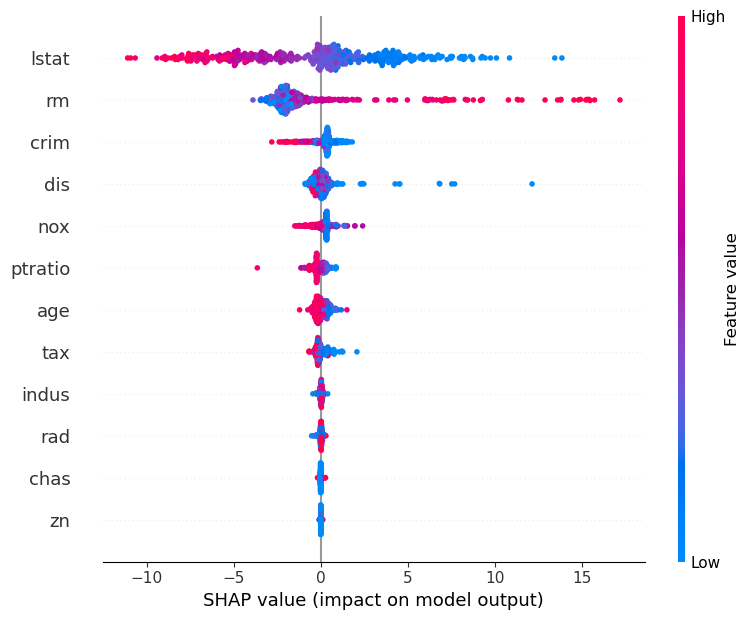

In [31]:
# 각 변수별 shapley value 분포를 한눈에 보여줍니다.
shap.summary_plot(shap_values1, x_train)

##### ② 특정 관점으로 Data point이 Shap Value 정렬

In [54]:
# shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, x_train)

##### ③ 특정 변수 값과 변수의 shap value 간의 관계

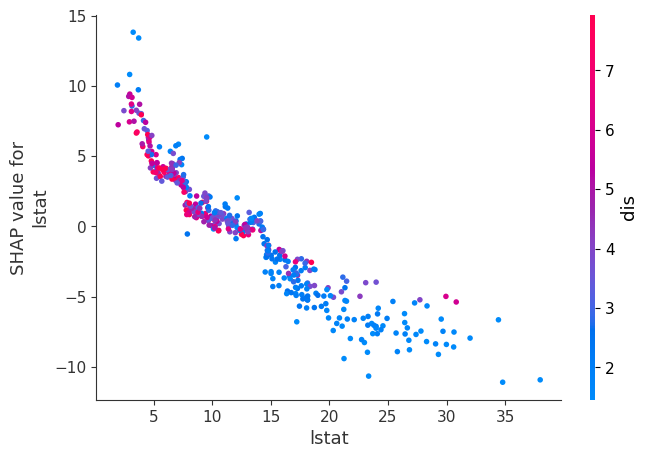

In [34]:
shap.dependence_plot('lstat', shap_values1, x_train)

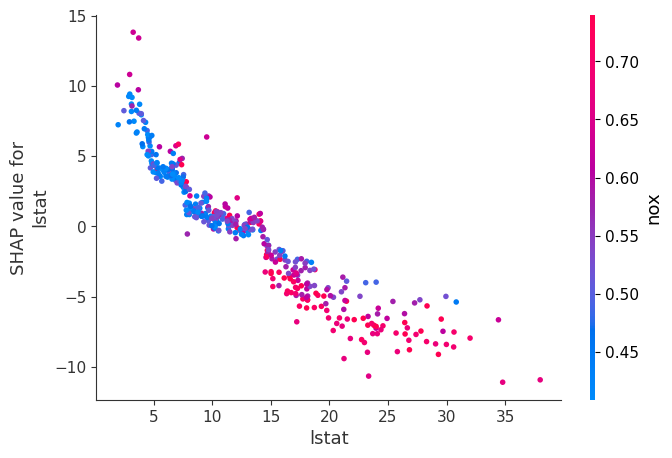

In [35]:
shap.dependence_plot('lstat', shap_values1, x_train, interaction_index = 'nox')

### 2. KernelExplainer

##### ① SVM 모델링

In [39]:
model2 = SVR()
model2.fit(x_train_s, y_train)

SVR()

###### ② Shap Value 만들기
* shap.KernelExplainer(모델.**predict**, x)
    * TreeExplainer는 그냥 모델을 넣었지만, KernelExpaliner는 모델.**predict**로 넣어야 한다.
* 데이터를 줄여서 10건만 수행한다.

In [40]:
explainer2 = shap.KernelExplainer(model2.predict, x_train_s)

# 10건만 줄여서 수행합니다.
shap_values2 = explainer2.shap_values(x_train_s[:10])

Using 404 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
shap_values2

array([[ 0.10519098,  0.14891478,  0.45284477, -0.09853   ,  0.30528773,
        -0.76373345,  0.76867214, -1.12042348, -0.24937668,  0.79325872,
         0.86705465, -0.18084915],
       [-0.38426078, -0.19900456, -0.4702012 , -0.17822418, -0.27529121,
        -1.89634627, -0.96095982,  0.38803203,  0.57213613, -0.77443581,
        -0.57916836, -0.02165694],
       [ 0.08989   , -0.310926  ,  0.11154573, -0.16985956,  0.14501779,
        -0.42122621, -0.90248252,  0.12193651, -0.15592721,  0.4111937 ,
        -1.32689913, -2.23056659],
       [ 0.14383612, -0.30378999, -0.28535272, -0.11059433,  0.45018799,
        -0.13557685,  0.6375002 , -0.30713439, -0.21775088, -0.08213998,
        -0.23173313,  0.19886664],
       [ 0.13016115, -0.30226134,  0.76934241, -0.08562412,  0.29529922,
        -1.58202538, -0.52549913,  0.66800628, -0.06139716,  0.61529849,
         1.08559674, -0.54731135],
       [ 0.16396894, -0.21842743, -0.32806751, -0.1578988 , -0.12364287,
        -0.45017486, -

In [55]:
# shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2, x_train_s[:10])

In [56]:
# shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0], x_train.iloc[0])

### 3. DeepExplainer

##### ① DL 모델링

In [44]:
# 간단한 DL 모델을 생성합니다.
nfeatures = x_train.shape[1]

clear_session()

model3 = Sequential([Dense(4, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(1)])

model3.compile(optimizer='adam', loss='mse')

history = model3.fit(x_train_s, y_train,
                     epochs = 100, batch_size = 64,
                    validation_split=0.2).history

Epoch 1/100
6/6 [==============================] - 1s 59ms/step - loss: 542.8778 - val_loss: 580.8514
Epoch 2/100
6/6 [==============================] - 0s 14ms/step - loss: 542.1525 - val_loss: 580.0718
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 541.4068 - val_loss: 579.2785
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 540.6091 - val_loss: 578.4523
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 539.7773 - val_loss: 577.5790
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 538.8945 - val_loss: 576.6564
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 537.9418 - val_loss: 575.6844
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 536.9545 - val_loss: 574.6613
Epoch 9/100
6/6 [==============================] - 0s 15ms/step - loss: 535.8946 - val_loss: 573.5396
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 534.7217 

6/6 [==============================] - 0s 14ms/step - loss: 272.2671 - val_loss: 280.1451
Epoch 81/100
6/6 [==============================] - 0s 16ms/step - loss: 268.4874 - val_loss: 275.6759
Epoch 82/100
6/6 [==============================] - 0s 16ms/step - loss: 264.7516 - val_loss: 271.4310
Epoch 83/100
6/6 [==============================] - 0s 14ms/step - loss: 260.9626 - val_loss: 267.2197
Epoch 84/100
6/6 [==============================] - 0s 13ms/step - loss: 257.3404 - val_loss: 262.8841
Epoch 85/100
6/6 [==============================] - 0s 13ms/step - loss: 253.6073 - val_loss: 258.5730
Epoch 86/100
6/6 [==============================] - 0s 13ms/step - loss: 249.8120 - val_loss: 254.3941
Epoch 87/100
6/6 [==============================] - 0s 15ms/step - loss: 246.2489 - val_loss: 250.2516
Epoch 88/100
6/6 [==============================] - 0s 13ms/step - loss: 242.7939 - val_loss: 246.3042
Epoch 89/100
6/6 [==============================] - 0s 15ms/step - loss: 239.4529 - va

##### ② Shap Value 만들기

* DeepExplainer로 부터 shap_values를 추출하면
    * **리스트 안에 np.array로 값이 저장**된다.(아니..왜...)
    * 그래서 이를 사용하려면 값을 뽑아내서(리스트[0])로 사용해야 한다.

In [45]:
explainer = shap.DeepExplainer(model3, x_train_s)
shap_values = explainer.shap_values(x_train_s)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [46]:
shap_values

[array([[-0.06265035,  0.13819355, -0.5543205 , ..., -0.52696883,
         -0.47739405,  0.02001713],
        [ 0.15763425, -0.15934079,  0.61513211, ...,  0.75239979,
          0.44958993,  0.01382184],
        [-0.03765804, -0.15934079, -0.31967913, ..., -0.33340006,
          0.66770381,  0.37573017],
        ...,
        [-0.02510112, -0.15934079,  0.61513211, ...,  0.75239979,
          0.44958993,  0.01433811],
        [-0.06133374, -0.15934079,  1.32374906, ..., -0.693317  ,
          0.14968335,  0.09023045],
        [-0.05161618,  0.12402525, -0.71106094, ..., -0.46345408,
         -1.51343498, -0.13486518]])]

In [47]:
# 리스트에서 값을 빼내기
shap_values = shap_values[0]

In [48]:
ev = explainer.expected_value.numpy()

In [57]:
# shap.initjs()
shap.force_plot(ev, shap_values, x_train)

In [58]:
# shap.initjs()
shap.force_plot(ev, shap_values[0], x_train.iloc[0])

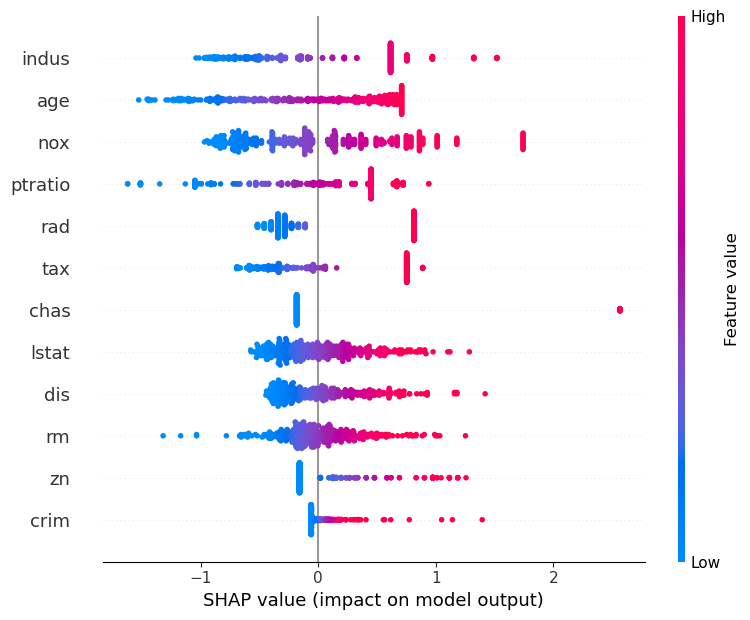

In [51]:
shap.summary_plot(shap_values, x_train)